In this notebook we calculate the conductance of junctions harboring Majorana zero energy modes. The junctions are infinite and of the type NS' or NS'S, where N stands for normal metal, S for superconductor and S' for  superconductor coexisting with ferromagnetism. The normal metal cosidered is a one-dimensional nanowire with strong spin-orbit coupling. The ferromagnetic superconductor is described by the [Lutchyn](https://link.aps.org/doi/10.1103/PhysRevLett.105.077001)-[Oreg](https://link.aps.org/doi/10.1103/PhysRevLett.105.177002) hamiltonian. The conductance is calculated within the scattering matrix formalism.    

To know more about the scattering matrix formalism the following references are recommended: 
- Quantum Transport: Introduction to Nanoscience, [Nazarov & Blanter](https://doi.org/10.1017/CBO9780511626906).
- Quantum Transport in Semiconductor Nanostructures, [Beenakker](https://www.sciencedirect.com/science/article/abs/pii/S0081194708600910)
- Scattering matrix approach to the description of quantum electron transport, [Lesovik & Sadovskyy](https://iopscience.iop.org/article/10.3367/UFNe.0181.201110b.1041).   

# Outline
- [1 - Hamiltonian of the junction](#1)
- [2 - NS' junction](#2)
  - [2.1 Building the model with kwant](#2.1)
  - [2.2 Spectrum and phase diagram](#2.2)
  - [2.3 The scattering matrix](#2.3)
  - [2.4 Conductance calculation](#2.4)
- [3 - NS'S junction](#3)
  - [3.1 Building the model with kwant](#3.1)
  - [3.2 Conductance calculation](#3.2)
 

<a name="1"></a>
# Hamiltonian of the junction

In units where energy and distance are measured in terms of $E_{so}=\frac{m^*\alpha^2}{2\hbar^2}$ and $\lambda_{so}=\frac{\hbar^2}{\alpha m^*}$, with $m^*$ and $\alpha$ the effective mass and the spin-orbit coupling of the nanowire, the dimensionless hamiltonian of the junction reads

\begin{equation}
\mathcal{H} = \Bigl[-\partial_x^2 + 2i\partial_x\sigma_z + V(x) - \mu(x)\Bigl]\tau_z + \mathbf{m}(x)\cdot\boldsymbol{\sigma} + \Delta(x)\tau_x,
\label{dimham}\tag{1}
\end{equation}

where $V(x)$ is a scalar potential simulating a barrier, $\mu(x)$ the chemical potential, $\mathbf{m}(x)$ the magnetization, and $\Delta(x)$ the superconducting gap. We use the python package [kwant](https://kwant-project.org/) to build this junction and calculate the conductance. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import kwant.continuum
import supp_func_kwant as sfk

from ipywidgets import interactive

C:\Users\victo\anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


<a name="2"></a>
## NS' junction

Given that the hamiltonian of the junction is provided in terms of the continuous operators $\mathbf{p}$ and $\mathbf{r}$, i.e. in a continuous notation, we use the [continuum](https://kwant-project.org/doc/1/reference/kwant.continuum) module of kwant to declare and build this hamiltonian. In this section we consider a junction defined by the following quantities, $V(x)=0$,
$$\mu(x)=\left\{
\begin{array}{cl}
\mu_{sc} & x \geq 0, \\
\mu_N & x < 0, 
\end{array}\right.$$

$$\mathbf{m}(x)=\left\{
\begin{array}{cl}
m_0\bigl(\,\sin{\theta}\cos{\phi},\sin{\theta}\sin{\phi},\cos{\theta}\,\bigr) & x \geq 0, \\
0 & x <0,
\end{array}\right.$$
and
$$\Delta(x)=\left\{
\begin{array}{cl}
\Delta_0 & \geq 0, \\
0 & x < 0.
\end{array}\right.$$

<a name="2.1"></a>
## Building the model with kwant

We build the infinite junction by attaching semi-infinite systems to a finite size system. The region where the finite size system is defined is usually called scattering region. The semi-infinite systems are called contacts or leads. In the following cells we define the hamiltonians of the sub-systems composing the junction. 

In [2]:
hamscatt = """
    (k_x**2 - mu(x, mu_N, mu_sc)) * kron(sigma_z, sigma_0)
    - 2 * k_x * kron(sigma_z, sigma_z)
    + Delta(x, Delta0) * kron(sigma_x, sigma_0)
    + m_x(x,m0,theta,phi) * kron(sigma_0, sigma_x)
    + m_y(x,m0,theta,phi) * kron(sigma_0, sigma_y)
    + m_z(x,m0,theta,phi) * kron(sigma_0, sigma_z)
"""

hamiltonian = kwant.continuum.sympify(hamscatt)
hamiltonian

Matrix([
[-2*k_x + k_x**2 + m_z(x, m0, theta, phi) - mu(x, mu_N, mu_sc),            m_x(x, m0, theta, phi) - I*m_y(x, m0, theta, phi),                                               Delta(x, Delta0),                                                               0],
[            m_x(x, m0, theta, phi) + I*m_y(x, m0, theta, phi), 2*k_x + k_x**2 - m_z(x, m0, theta, phi) - mu(x, mu_N, mu_sc),                                                              0,                                                Delta(x, Delta0)],
[                                             Delta(x, Delta0),                                                            0, 2*k_x - (k_x**2 - mu(x, mu_N, mu_sc)) + m_z(x, m0, theta, phi),               m_x(x, m0, theta, phi) - I*m_y(x, m0, theta, phi)],
[                                                            0,                                             Delta(x, Delta0),              m_x(x, m0, theta, phi) + I*m_y(x, m0, theta, phi), -2*k_x - (k_x**2 - mu(x, mu_N, mu

In [3]:
ham_str_nl = """
    (k_x**2 - mu_N) * kron(sigma_z, sigma_0)
    - 2 * k_x * kron(sigma_z, sigma_z)
"""

In [4]:
ham_str_scl = """
    (k_x**2 - mu_sc) * kron(sigma_z, sigma_0)
    - 2 * k_x * kron(sigma_z, sigma_z)
    + Delta0 * kron(sigma_x, sigma_0)
    + m_x(L2,m0,theta,phi) * kron(sigma_0, sigma_x)
    + m_y(L2,m0,theta,phi) * kron(sigma_0, sigma_y)
    + m_z(L2,m0,theta,phi) * kron(sigma_0, sigma_z)
"""

As already discussed in previous notebooks, the parameters entering in the string hamiltonians are provided to the algorithm in a python dictionary.   

In [5]:
alat=0.25
Lleft=-4;  Lright=8
default = dict(Delta0=2.0, mu_N=2.0, mu_sc=4.0, m0=3.0, theta=0.3, phi=0.5, 
               mu=sfk.mu_f, Delta=sfk.delta_f, m_x=sfk.mx_f, m_y=sfk.my_f, m_z=sfk.mz_f,
               L1=Lleft, L2=Lright)

The function `K_junct()` builds the infinite junction from the string hamiltonians and some other important quantities. Notice the new parameter `conservation_law` of the class `Builder`. This parameter appears convenient in the calculation of the scattering matrix. If the semi-infinite systems have a symmetry, one can use a basis associated with that symmetry to project the scattering states into this basis.    

In [6]:
def K_junct(leftL,rightL, alat, scat_reg, lead_left, lead_right):

    def interval_shape(x_min, x_max):
        def shape(site):
            return x_min <= site.pos[0] <= x_max

        return shape

    def shape_lead(s): return s.pos[0] <= 0

    eh_sym = np.diag([-1,-1,1,1])
    
    syst = kwant.Builder()
    scatt_template = kwant.continuum.discretize(scat_reg, 'x', grid=alat)
    syst.fill(
        scatt_template,
        shape=interval_shape(leftL, rightL),
        start=[leftL],
    )
        
    left_lead = kwant.Builder(kwant.TranslationalSymmetry([-alat]))
    template_left_lead = kwant.continuum.discretize(
        lead_left, 'x', grid=alat)
    left_lead.fill(template_left_lead, shape_lead, (leftL,))
    left_lead.conservation_law = eh_sym
    syst.attach_lead(left_lead)
        
    right_lead = kwant.Builder(kwant.TranslationalSymmetry([alat]))
    template_right_lead = kwant.continuum.discretize(
        lead_right, 'x', grid=alat)
    right_lead.fill(template_right_lead, shape_lead, (rightL,))
    syst.attach_lead(right_lead)

    return syst.finalized()

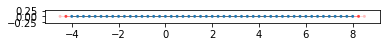

Plotting the nodes and vertices of the lattice


In [7]:
latsyst = K_junct(Lleft,Lright, alat, 
                       scat_reg=hamscatt, lead_left=ham_str_nl, lead_right=ham_str_scl)
kwant.plot(latsyst)
print('Plotting the nodes and vertices of the lattice')

The lines of code below check the profiles of the input functions.

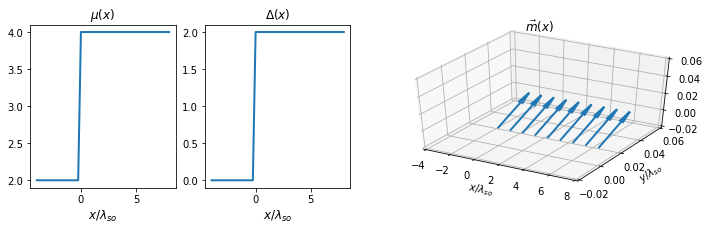

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,3))

x_vals = np.linspace(Lleft,Lright, int((Lright-Lleft)/alat)+1)
x_red = x_vals[::4]

mu_vals = [sfk.mu_f(x, default.get('mu_N'),default.get('mu_sc')) for x in x_vals]

mx_vals = np.array([sfk.mx_f(x, default.get('m0'),default.get('theta'),default.get('phi')) 
           for x in x_red])

my_vals = np.array([sfk.my_f(x, default.get('m0'),default.get('theta'),default.get('phi')) 
           for x in x_red])

mz_vals = np.array([sfk.mz_f(x, default.get('m0'),default.get('theta'),default.get('phi'))
           for x in x_red])

gap_vals = [sfk.delta_f(x, default.get('Delta0')) for x in x_vals]

title_list = [r'$V(x)$',r'$\mu(x)$',r'$\Delta(x)$',r'$\vec{m}(x)$']

ax = fig.add_subplot(1, 4, 1)
ax.plot(x_vals, mu_vals, '-', lw=2)
ax.set_xlabel(r'$x/\lambda_{so}$', fontsize=12)
ax.set_title(title_list[1])
    
ay = fig.add_subplot(1, 4, 2)
ay.plot(x_vals, gap_vals, '-', lw=2)
ay.set_xlabel(r'$x/\lambda_{so}$', fontsize=12)
ay.set_title(title_list[2])

az = fig.add_subplot(1, 4, (3,4), projection='3d')
az.quiver(x_red,np.zeros(1),np.zeros(1),mx_vals,my_vals,mz_vals, length=0.012, linewidths=2)
az.set_xlim(x_red[0],x_red[-1])
az.set_ylim(-0.02,0.06)
az.set_zlim(-0.02,0.04)
az.set_yticks(np.linspace(-0.02,.06,5))
az.set_zticks(np.linspace(-0.02,.06,5))
az.set(xlabel=r'$x/\lambda_{so}$', ylabel=r'$y/\lambda_{so}$',zlabel=r'$z$')
az.set_title(title_list[3])
az.view_init(40,-60)

<a name="2.2"></a>
## Spectrum and phase diagram

After setting and checking the input functions let's simulate the NS' junction. The function below plots the energy in the leads (semi-infinite) regions. Given the homogeneity of the regions, $k_x$ is a conserved quantity (good quantum number) so one can plot the energy as a function of $k_x$.

In [9]:
def bands(chem,m_zero,polar):

    default['mu_sc'] = chem
    default['m0'] = m_zero
    default['theta'] = polar
    
    xlim=8.0
    D0 = default.get('Delta0')
    
    gapless = D0/np.cos(polar*np.pi)
    
    fig, sub = plt.subplots(1,3, figsize=(12,4))
    kxarr = np.linspace(-1.09,1.09,123)

    for ii in range(2):
        kwant.plotter.bands(latsyst.leads[ii], params=default, momenta=kxarr, ax=sub[ii])
        sub[ii].set_xlabel(r'$k_xa$', fontsize=12)
        sub[ii].set_ylim(-8,8)

    sfk.ph_diagram(sub[2], D0, polar, xlim)
    
    sub[1].plot(np.linspace(kxarr[0],kxarr[-1],17), np.zeros(17), '--k', alpha=0.4)
    
    sub[2].scatter(m_zero,chem, s=50, color='red')

    sub[0].set_title('(a) Normal lead')
    sub[0].set_ylabel(r'$E/E_{SO}$', fontsize=12)
    sub[1].set_title('(b) Supercond lead')
    sub[2].set_xlabel(r'$m_0/E_{so}$', fontsize=12)
    sub[2].set_ylabel(r'$\frac{\mu}{E_{so}}$', fontsize=18, rotation='horizontal',labelpad=6)
    sub[2].set_title('(c) Phase diagram')
    
    plt.show()

In [10]:
w = interactive(bands, chem=(-5.0,5.0), m_zero=(0.0,5.0), polar=(0.1,0.5))
display(w)

interactive(children=(FloatSlider(value=0.0, description='chem', max=5.0, min=-5.0), FloatSlider(value=2.5, de…

Energy spectra of the bare nanowire and the ferromagnetic-superconducting nanowire, (a) and (b) respectively. (c) phase diagram of the ferromagnetic-superconducting nanowire. The buttons `chem`, `m_zero`, and `polar` allow the manipulation of parameters $\mu_{sc}$, $m_0$, and $\theta/\pi,$ respectively. By sliding the buttons one can drive the nanowire to different phases. The lines separating the different phases are called transition lines, $\mu^2 +\Delta_0^2 = m_0^2$ and $\Delta_0=m_0\cos{\theta}$. At these lines the gap closes. This is a known feature of systems with different topological phases, the transition between the phases is followed by a gap closing. TG (NTG) stands for trival gapped (nontrivial gapped), and TGL (NTGL) for trivial gapless (nontrivial gapless).

<a name="2.3"></a>
## The scattering matrix

To introduce the scattering matrix let's consider that superconductor S' is in any of the two gapped phases, i.e. $\Delta_0<m_0\cos{\theta}$. Let's also consider energies within superconducting gap. Under these conditions, all states in S' are exponentially decaying (attenuated). Then, incident states from the normal metal are all reflected back, and since the right lead is a superconductor two cases are possible: electron and hole reflections. These scattering processes are also called normal and Andreev reflections, respectively. Now, how can we identify the incident and reflected states and normal and Andreev reflections? kwant defines the incident (reflected) states as those with positive (negative) velocity. Moreover, with the parameter `conservation_law` provided earlier, kwant knows that there is a symmetry ($\tau_z$) that allows to project the incident and reflected states into the eigenstates of this symmetry. Since the eigenstates of $\tau_z$ span electron and hole sub-spaces, incident and reflected states can be divided between electron and hole states. By collecting all these reflection processes in a matrix we arrive to the following form of the scattering matrix,

$$
S(E) = \left(
\begin{array}{cc}
\hat{r}_{ee} & \hat{r}_{he} \\
\hat{r}_{eh} & \hat{r}_{hh}
\end{array}
\right),$$

where $\hat{r}_{ee}$ ($\hat{r}_{he}$) account for all electron-electron (electron-hole) reflections. On the other hand, $\hat{r}_{hh}$ ($\hat{r}_{eh}$) account for all hole-hole (hole-electron) reflections. Let's define the function `scatt_labels()` to understand what are all the processes defining the scattering matrix.


In [11]:
def scatt_labels(EE):
    fig, sub = plt.subplots(1,1, figsize=(5,4))
    kxarr = np.linspace(-1,1,177)

    kwant.plotter.bands(latsyst.leads[0], params=default, momenta=kxarr, ax=sub)
    sub.set_ylim(-5,5)
    prop_modes = latsyst.leads[0].modes(params=default, energy=EE)
    momentarr= prop_modes[0].momenta
    velarr= prop_modes[0].velocities
    q_cons= prop_modes[0].block_nmodes

    vxx = np.sqrt(2)*np.cos(np.arctan(velarr))
    vyy = np.sqrt(2)*np.sin(np.arctan(velarr))
    nhlf = int(0.5*len(velarr))
  
    sub.plot(momentarr,EE*np.ones(len(momentarr)), 's', color='k', ms=8, label='momenta')
    sub.plot(kxarr,EE*np.ones(len(kxarr)), '--k', alpha=0.5)
    
    clist = ['magenta','blue']
    lslist = ['-', '--']
    varbool = True
    for mm in range(2):
        for ll, jj in enumerate(range(0,nhlf+1,nhlf)):
            for ii in range(q_cons[mm]):
                sub.arrow(momentarr[jj+ii+mm*q_cons[0]],EE,vxx[jj+ii+mm*q_cons[0]],vyy[jj+ii+mm*q_cons[0]], 
                          width=0.05, length_includes_head=True, color=clist[ll], fill=varbool, ls=lslist[mm])
        varbool = not varbool

    sub.set_xlim(kxarr[0],kxarr[-1])
    sub.set_ylabel(r'$E/E_{SO}$', fontsize=12)
    sub.set_xlabel(r'$k_xa$', fontsize=12)
    sub.legend()

In [12]:
w = interactive(scatt_labels, EE=(-4.0,4.0))
display(w)

interactive(children=(FloatSlider(value=0.0, description='EE', max=4.0, min=-4.0), Output()), _dom_classes=('w…

Energy as a function of momentum for the bare nanowire. Full (empty) arrows represent the velocity of the electrons (holes). States with positive (negative) velocities are taken by kwant as incident (reflected) states. For energies (E) within the inteval $[-3,3]$, the number of incident and reflected states is four, two from electrons and two from holes. The scattering matrix in this interval then has dimension $4\times 4$. For $|E|>3$ the reflections are all normal. Electrons (holes) being reflected as electrons (holes) for $E>3$ $(E<-3)$. The user can slide the button `EE` to change the energy.  

In kwant the function `smatrix(sys[, energy, args, out_leads, …])` from the library of [solvers](https://kwant-project.org/doc/1/reference/kwant.solvers) provides an object containing the scattering matrix and other information about the contacts. 

In [13]:
Smtx = kwant.smatrix(latsyst, energy=1e-2, params=default)

# the attribute `data` allows to retrieve the scattering matrix (values) 
np.round(Smtx.data, 3)

array([[ 0.198-0.034j, -0.391+0.099j, -0.141-0.369j, -0.761-0.249j],
       [ 0.387-0.105j, -0.751+0.268j,  0.092+0.188j,  0.39 +0.088j],
       [-0.359+0.178j, -0.164+0.097j,  0.49 +0.635j, -0.4  -0.009j],
       [ 0.187-0.777j,  0.063-0.401j,  0.396+0.015j, -0.131+0.15j ]])

In [14]:
# the method `submatrix()` alllows to retrieve subblocks of the scattering matrix.
# The contacts have the following labels: normal contact (0), superconducting contact (1)
# For example the electron-electron subblock of the reflection from and to the 
# normal contact is obtained as follows:
np.round(Smtx.submatrix((0,0),(0,0)), 3)

array([[ 0.198-0.034j, -0.391+0.099j],
       [ 0.387-0.105j, -0.751+0.268j]])

In [15]:
# the electron-hole (e->h) subblock of the reflection from and to the 
# normal contact is obtained as follows:
np.round(Smtx.submatrix((0,1),(0,0)), 3)

array([[-0.359+0.178j, -0.164+0.097j],
       [ 0.187-0.777j,  0.063-0.401j]])

In [16]:
# Given the energy and parameters provided, there is any  particle transmission
# from contact 0 to contact 1, let's see that:
np.round(Smtx.submatrix(1,0), 3)

array([], shape=(0, 4), dtype=complex128)

<a name="2.4"></a>
## Conductance calculation

Let's consider some mesoscopic or nanoscale system connected to two contacts. The contacts act as reservoirs with well defined thermodynamic quantities, such as temperature and chemical potential. The conductance $G$ is the proportionality constant between the current $I$ flowing through the mesoscopic/nanoscale system and the voltage $V$ applied to the contacts, $I = G V$. The conductance depends on the parameters of the system but also on the geometry of the sample. The Landauer formula provides an expression for the current in terms of all the transmission amplitudes involved in the measurement, 

$$I = \frac{e}{h}\int_0^{\infty} dE \bigl(f_1(E) - f_2(E)\bigr)\mathrm{Tr}\bigl[\hat{t}(E)\,\hat{t}^{\dagger}(E)\bigr],$$

where $f_i(E)=\frac{1}{1+e^{(E-\mu_i)/k_BT_i}}$ is the fermi distribution function of contact $i$, and $\hat{t}(E)$ is the transmission subblock of the scattering matrix. In many textbooks $e$ is replaced by $2e$, that is when the system and contacts are spin degenerate. It is quite common to define an energy dependent conductance (the spectral conductance) as follows, 
$\mathscr{G}(E)=\frac{e^2}{h}\mathrm{Tr}\bigl[\hat{t}(E)\,\hat{t}^{\dagger}(E)\bigr]$. An expression for the spectral conductance when the contacts or the mesoscopic system involve a superconductor reads, see [Beenakker](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.46.12841) for details, 

\begin{eqnarray}
\mathscr{G}(E) &=&\frac{e^2}{h} \mathrm{Tr}\bigl[1 - \hat{r}_{ee}^\dagger(E) \hat{r}_{ee}(E) + 
\hat{r}_{he}^\dagger(E) \hat{r}_{he}(E)\bigl],\\
&=& \frac{e^2}{h} \bigl(N_{m} -  R_{ee}(E) + R_{he}(E)\bigr),
\end{eqnarray}

where $N_{m}$ is the number of propagating modes, and $R_{ee}$ ($R_{he}$) is the normal (Andreev) reflection spectral density. The function below plots $\mathscr{G}$, $R_{ee}$, and $R_{he}$ for the $NS'$ junction.

In [17]:
def spect_diag_trans(chem,m_zero,polar):

    default['mu_sc'] = chem
    default['m0'] = m_zero
    default['theta'] = polar
    
    xlim=8.0
    D0 = default.get('Delta0')
    
    gapless = D0/np.cos(polar*np.pi)
    
    fig, sub = plt.subplots(1,3, figsize=(12,4))
    kxarr = np.linspace(-1.0,1.0,99)
    
    gap = sfk.gap(default, alat, ham_str_scl)
    
    Earr, Traone, Tratwo, modes = sfk.cond_trans(latsyst,default,np.array([-gap,gap]),39)
    
    kwant.plotter.bands(latsyst.leads[1], params=default, momenta=kxarr, ax=sub[0])

    sfk.ph_diagram(sub[1], D0, polar, xlim)
    
    for ii in range(-1,2,2):
        sub[0].plot(np.linspace(kxarr[0],kxarr[-1],17), ii*gap*np.ones(17), '--k', alpha=0.8)
    
    sub[1].scatter(m_zero,chem, s=50, color='red')
    sub[2].plot(Earr, Traone, 'k', label=r'$R_{ee}$')
    sub[2].plot(Earr, Tratwo, 'b', label=r'$R_{he}$')
    sub[2].plot(Earr, modes - Traone + Tratwo, 'm', label=r'$\mathscr{G}$')
    
    sub[0].set_xlabel(r'$k_xa$', fontsize=12)
    sub[0].set_ylabel(r'$E/E_{SO}$', fontsize=12)
    sub[0].set_title('(a) Supercond lead')
    sub[0].set_ylim(-4,4)
    sub[1].set_xlabel(r'$m_0/E_{so}$', fontsize=12)
    sub[1].set_ylabel(r'$\frac{\mu}{E_{so}}$', fontsize=18, rotation='horizontal',labelpad=6)
    sub[1].set_title('(b) Phase diagram')
    sub[2].set_xlabel(r'$E/E_{so}$', fontsize=12)
    sub[2].legend(frameon=False, fontsize=14)
    sub[2].set_title('(c)')
    
    plt.show()

In [18]:
w = interactive(spect_diag_trans, chem=(-5.0,5.0), m_zero=(0.0,5.0), polar=(0.1,0.5))
display(w)

interactive(children=(FloatSlider(value=0.0, description='chem', max=5.0, min=-5.0), FloatSlider(value=2.5, de…

(a) Energy spectra of the ferromagnetic-superconducting nanowire. The dash lines show the energy gap. (b) phase diagram of the ferromagnetic-superconducting nanowire. TG (NTG) stands for trival gapped (nontrivial gapped), and TGL (NTGL) for trivial gapless (nontrivial gapless). The buttons `chem`, `m_zero`, and `polar` allow the manipulation of parameters  $\mu_{sc}$, $m_0$, and $\theta/\pi$, respectively. (c) spectral conductance $\mathscr{G}$, and the normal and Andreev reflection spectral densities, $R_{ee}$, and $R_{he}$, respectively.

Notice that at zero energy and in the phase harboring Majoranas (the NTG phase) $R_{ee}=R_{he}=1$. Notice also that as consequence of $R_{ee}=R_{he}=1$, at zero energy the conductance is quantized to $\frac{2e^2}{h}$, [He et al.](https://link.aps.org/doi/10.1103/PhysRevLett.112.037001) This quantization appears as distinctive feature of Majoranas [Prada et al.](https://www.nature.com/articles/s42254-020-0228-y) The user is encouraged to slide the buttons of the figure to drive the system, for example, to the TG phase and see that the conductance is not robustly quantized in this phase.   

<a name="3"></a>
## NS'S junction

In this section we consider a junction defined by the following quantities,

$$V(x)=\left\{
\begin{array}{cl}
V_0 & -L_b \leq x < 0,\\
0 & \mathrm{elsewhere},
\end{array}\right.$$ 

$$\mu(x)=\left\{
\begin{array}{cl}
\mu_N & x < 0,\\
\mu_1 & 0 \leq x \leq L, \\
\mu_2 & x > L, 
\end{array}\right.$$ 

$$\mathbf{m}(x)=\left\{
\begin{array}{cl}
m_0\bigl(\,\sin{\theta}\cos{\phi},\sin{\theta}\sin{\phi},\cos{\theta}\,\bigr) & 0 \leq x \leq L,\\
0 & \mathrm{elsewhere},
\end{array}\right.$$ 
and
$$\Delta(x)=\left\{
\begin{array}{cl}
\Delta_0 & \geq 0, \\
0 & x < 0.
\end{array}\right.$$


With the profile above the ferromagnetic-superconducting NW is finite and in the topologically nontrivial phase the system harbors two Majoranas, one at each end. Notice that a square potential barrier is introduced at the $NS'$ interface. The barrier controls the coupling of the subgap states in the superconductor to the electron and hole states in the normal metal.   

<a name="3.1"></a>
## Building the model with kwant

In the following cells we define the hamiltonians of the scattering region and the contacts. 

In [19]:
hamscatt = """
    (k_x**2 + V(x,L_b,V_0)- mu(x, L,mu_N, mu_1,mu_2)) * kron(sigma_z, sigma_0)
    - 2 * k_x * kron(sigma_z, sigma_z)
    + Delta(x, Delta0) * kron(sigma_x, sigma_0)
    + m_x(x,L,m0,theta,phi) * kron(sigma_0, sigma_x)
    + m_y(x,L,m0,theta,phi) * kron(sigma_0, sigma_y)
    + m_z(x,L,m0,theta,phi) * kron(sigma_0, sigma_z)
"""

hamiltonian = kwant.continuum.sympify(hamscatt)
hamiltonian

Matrix([
[-2*k_x + k_x**2 + V(x, L_b, V_0) + m_z(x, L, m0, theta, phi) - mu(x, L, mu_N, mu_1, mu_2),                                  m_x(x, L, m0, theta, phi) - I*m_y(x, L, m0, theta, phi),                                                                           Delta(x, Delta0),                                                                                           0],
[                                  m_x(x, L, m0, theta, phi) + I*m_y(x, L, m0, theta, phi), 2*k_x + k_x**2 + V(x, L_b, V_0) - m_z(x, L, m0, theta, phi) - mu(x, L, mu_N, mu_1, mu_2),                                                                                          0,                                                                            Delta(x, Delta0)],
[                                                                         Delta(x, Delta0),                                                                                        0, 2*k_x - (k_x**2 + V(x, L_b, V_0) - mu(x, L, mu_N, mu_1, mu_2)) + m_z(x, L

In [20]:
ham_str_nl = """
    (k_x**2 - mu_N) * kron(sigma_z, sigma_0)
    - 2 * k_x * kron(sigma_z, sigma_z)
"""

In [21]:
ham_str_scl = """
    (k_x**2 - mu_2) * kron(sigma_z, sigma_0)
    - 2 * k_x * kron(sigma_z, sigma_z)
    + Delta0 * kron(sigma_x, sigma_0)
"""

In [22]:
alat=0.25
Lleft=-4;  Lright=12
default = dict(Delta0=2.0, V_0=2, mu_N=2.0, mu_1=1.0, mu_2=4.0, m0=3.0, theta=0.3, phi=0.5, 
               V=sfk.V_rect, mu=sfk.mu_g, Delta=sfk.delta_f, m_x=sfk.mx_g, m_y=sfk.my_g, m_z=sfk.mz_g,
               L=Lright, L_b=2)

We use the already defined function `K_junct()` to build the tight binding system associated to the junction.

In [23]:
latsyst = K_junct(Lleft,Lright, alat, 
                       scat_reg=hamscatt, lead_left=ham_str_nl, lead_right=ham_str_scl)

Let's plot the spatial profiles of $V(x)$, $\mu(x)$, $\mathbf{m}(x)$, and $\Delta(x)$ to check that the functions are well set.

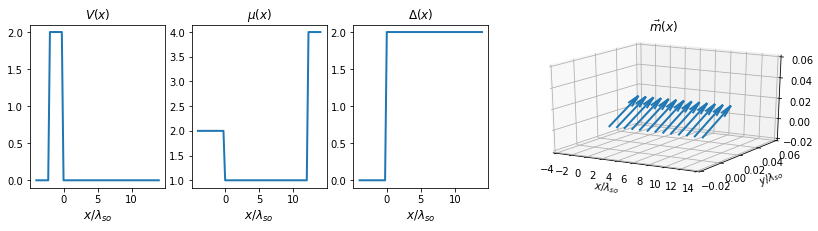

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,3))

x_vals = np.linspace(Lleft,Lright+8*alat, int((Lright-Lleft)/alat)+9)
x_red = x_vals[::4]

barr_vals = [sfk.V_rect(x, default.get('L_b'), default.get('V_0'))
             for x in x_vals]

mu_vals = [sfk.mu_g(x, default.get('L'), default.get('mu_N'), default.get('mu_1'),default.get('mu_2'))
           for x in x_vals]

mx_vals = np.array([sfk.mx_g(x, default.get('L'), default.get('m0'),default.get('theta'),default.get('phi')) 
           for x in x_red])

my_vals = np.array([sfk.my_g(x, default.get('L'), default.get('m0'),default.get('theta'),default.get('phi')) 
           for x in x_red])

mz_vals = np.array([sfk.mz_g(x, default.get('L'), default.get('m0'),default.get('theta'),default.get('phi'))
           for x in x_red])

gap_vals = [sfk.delta_f(x, default.get('Delta0')) for x in x_vals]

title_list = [r'$V(x)$',r'$\mu(x)$',r'$\Delta(x)$',r'$\vec{m}(x)$']

ax = fig.add_subplot(1, 5, 1)
ax.plot(x_vals, barr_vals, '-', lw=2)
ax.set_xlabel(r'$x/\lambda_{so}$', fontsize=12)
ax.set_title(title_list[0])

ax = fig.add_subplot(1, 5, 2)
ax.plot(x_vals, mu_vals, '-', lw=2)
ax.set_xlabel(r'$x/\lambda_{so}$', fontsize=12)
ax.set_title(title_list[1])
    
ay = fig.add_subplot(1, 5, 3)
ay.plot(x_vals, gap_vals, '-', lw=2)
ay.set_xlabel(r'$x/\lambda_{so}$', fontsize=12)
ay.set_title(title_list[2])

az = fig.add_subplot(1, 5, (4,5), projection='3d')
az.quiver(x_red,np.zeros(1),np.zeros(1),mx_vals,my_vals,mz_vals, length=0.012, linewidths=2)
az.set_xlim(x_red[0],x_red[-1])
az.set_ylim(-0.02,0.06)
az.set_zlim(-0.02,0.04)
az.set_yticks(np.linspace(-0.02,.06,5))
az.set_zticks(np.linspace(-0.02,.06,5))
az.set(xlabel=r'$x/\lambda_{so}$', ylabel=r'$y/\lambda_{so}$',zlabel=r'$z$')
az.set_title(title_list[3])
az.view_init(20,-60)

Let's plot the energy spectrum of the contacts to check that they are well set.

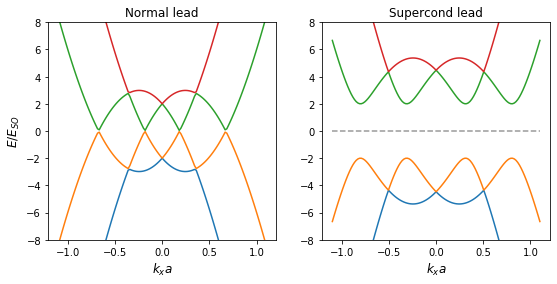

In [25]:
xlim=8.0
D0 = default.get('Delta0')

fig, sub = plt.subplots(1,2, figsize=(9,4))
kxarr = np.linspace(-1.1,1.1,123)

for ii in range(2):
    kwant.plotter.bands(latsyst.leads[ii], params=default, momenta=kxarr, ax=sub[ii])
    sub[ii].set_xlabel(r'$k_xa$', fontsize=12)
    sub[ii].set_ylim(-8,8)

sub[1].plot(np.linspace(kxarr[0],kxarr[-1],17), np.zeros(17), '--k', alpha=0.4)


sub[0].set_title('Normal lead')
sub[0].set_ylabel(r'$E/E_{SO}$', fontsize=12)
sub[1].set_title('Supercond lead')

plt.show()

Energy spectrum of the normal $N$ and superconducting $S$ contacts.

Let's now plot the the spectral conductance of the $NS'S$ junction. 

In [26]:
def diag_trans_finite(chem,polar, barr):
    
    default['mu_1'] = chem
    default['theta'] = polar
    default['V_0'] = barr    
    
    fig, sub = plt.subplots(1,2, figsize=(9.4,4))

    polar = default['theta'] 

    xlim=8.0
    D0 = default.get('Delta0')
    gapless = D0/np.cos(polar*np.pi) 

    sfk.ph_diagram(sub[0], D0, polar, xlim)

    m0arr = np.linspace(1.15*D0,0.9*gapless,5)
    Elims= [0,0.15*default.get('Delta0')]
    marklist = ['o','s','v','p','>']
    for ii, mzero in enumerate(m0arr):
        default['m0'] = mzero
        arrE, arrTee, arrThe, arrmds = sfk.cond_trans(latsyst, default, Elims, 43)
        cond = arrmds-arrTee+arrThe
        sub[1].plot(np.append(-arrE[::-1],arrE[1:]),np.append(cond[::-1],cond[1:]), 
                    label=r'$m_0/E_{so}\!=\!$'+str.format('{:.2f}',mzero))
        sub[0].scatter(mzero,default.get('mu_1'), marker=marklist[ii], s=60, color='C'+str(ii))
    
    sub[0].set_title('(a)')
    sub[0].set_xlabel(r'$m_0/E_{so}$', fontsize=12)
    sub[0].set_ylabel(r'$\frac{\mu}{E_{so}}$', fontsize=18, rotation='horizontal',labelpad=6)
    sub[1].set_title('(b)')
    sub[1].set_xlabel(r'$E/E_{SO}$', fontsize=12)
    sub[1].set_ylim(0,4)
    sub[1].set_yticks(np.linspace(0,4,9))
    sub[1].set_ylabel(r'$\mathscr{G}$', fontsize=18, rotation='horizontal',labelpad=11)
    sub[1].legend(frameon=False)


In [27]:
w = interactive(diag_trans_finite, chem=(-5.0,5.0), polar=(0.1,0.5), barr=(0.0,4.0))
display(w)

interactive(children=(FloatSlider(value=0.0, description='chem', max=5.0, min=-5.0), FloatSlider(value=0.30000…

(a) Phase diagram of the ferromagnetic-superconducting nanowire. TG (NTG) stands for trival gapped (nontrivial gapped), and TGL (NTGL) for trivial gapless (nontrivial gapless). The buttons `chem`, `polar`, and `barr` allow the manipulation of parameters  $\mu_1$, $\theta/\pi$, and $V_0$, respectively. Colored symbols indicate five different values of $m_0$ between $\Delta_0$ and $\Delta_0/\!\cos{\theta}$. (b) Spectral conductance $\mathscr{G}$ for the five different values of $m_0$ in panel (a).       

Notice that the spectral conductance at $E=0$ takes different values as $m_0$ changes. This is a consequence of the hybridization between the Majoranas at the two edges [Das Sarma et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.220506)  [Rainis et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.87.024515) and [Prada et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.180503) Increasing the length ($L$) of the ferromagnetic-superconducting NW will decrease the linewidth of the peak/dip. In the limit where $L \rightarrow \infty$ one should recover the quantization $\frac{2e}{h}$ of the $NS'$ junction. 

Users are encouraged to increase the potential barrier by sliding the button `barr` to see how the width of the resonance peak changes. Another suggestion is to increase the precession cone angle to $0.4$ to have $m_0$'s more spaced. Finally, an increase in $\mu_1$ to have some of the five points in the TG phase is recommended.